In [1]:
import numpy as np

def meta(dataset):
    filepath = 'data/'+dataset+'/centers.txt'
    no_of_gaussians = None
    dimensions = None
    weights = list()
    centers = list()
    f = open(filepath, 'r')
    lines = f.readlines()
    for i in xrange(len(lines)):
        if i == 0:
            lines[i] = map(int, lines[i][:-2].split(','))
            no_of_gaussians, dimensions = lines[0]
        elif i == 1:
            lines[i] = map(float, lines[i][:-3].split(','))
            weights = lines[1]
            assert(sum(weights) == 1.0)
        else:
            centers.append(np.array(map(float, lines[i][:-3].split(','))))
    return no_of_gaussians, dimensions, weights, centers #outputs all data in lists or in values



def covariance_data(no_of_gaussians, dataset):
    cov_matrices = list()
    for i in xrange(no_of_gaussians):
        filepath = 'data/'+dataset+'/cov_'+str(i+1)+'.txt'
        cov = np.loadtxt(filepath, delimiter=',', comments='#')
        cov_matrices.append(cov)
    return cov_matrices #returned as list of numpy matrices

In [2]:
import numpy as np 
import random, math


class GaussianMMSampler(object):
    def __init__(self, weights , mean, cov_matrices):
        self.weights = weights
        self.means = mean
        self.cov_matrices = cov_matrices
        self.no_of_gaussians = len(weights)


    def mixture_sampling(self, no_of_points):
        points = list()
        gaussian_id = list()
        for i in xrange(self.no_of_gaussians):
            gs = GaussianSampler(self.means[i], self.cov_matrices[i])
            sample_points = gs.sample_list(int(math.ceil(self.weights[i]*no_of_points)))
            points.extend(sample_points)
            for j in xrange(int(math.ceil(self.weights[i]*no_of_points))):
                gaussian_id.append(i+1)
        assert(len(points) >= no_of_points)
        return points, gaussian_id



class GaussianSampler(object):
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.zero = np.zeros(self.mean.shape)

    def sample(self):
        return np.random.multivariate_normal(self.zero, self.cov) + self.mean

    def sample_list(self, no_of_points):
        sample_points = list()
        for i in xrange(no_of_points):
            point = np.random.multivariate_normal(self.zero, self.cov) + self.mean
            sample_points.append(point)
        return sample_points #being returnd as list of points.

class GaussianRSampler(GaussianSampler):
    def __init__(self, dimensions):
        self.dimensions = dimensions
        self.points = self.initilize_points()
        self.mean = self.initilize_mean()
        self.cov = self.initilize_cov_matrix()
        self.zero = np.zeros(self.mean.shape)

    def initilize_points(self):
        return np.random.rand(self.dimensions, self.dimensions+100)*2

    def initilize_mean(self):
        k =  np.reshape(np.mean(self.points, axis=1), (self.dimensions, ))
        assert(k.shape[0] == self.dimensions)
        print k
        return k

    def initilize_cov_matrix(self):
        k = np.cov(self.points)
        assert(k.shape[0] == self.dimensions)
        assert(k.shape[1] == self.dimensions)
        return k
        
    def distance(self, point):
        return np.linalg.norm(point-self.mean)

    def sample_distance(self):
        point = np.random.multivariate_normal(self.zero, self.cov) + self.mean
        return np.linalg.norm(point-self.mean)

# Code for estimation maximisation

In [89]:
import numpy as np
import random
from scipy.stats import multivariate_normal

class EstimationMaximisation(object):
    def __init__(self, points, no_of_iterations, no_of_gaussians, parametric="Yes"):
        self.points = points #list of numpy arrays
        self.no_of_points = len(self.points)
        self.no_of_iterations = no_of_iterations
        self.parametric = parametric
        self.no_of_gaussians = no_of_gaussians
        self.dimension = points[0].shape[0]
        self.means = None
        self.cov_matrices = None
        self.weights = None
        self.gamma = None

    def initilize_means(self):
        means = list()
        for i in xrange(self.no_of_gaussians):
            means.append(np.random.rand(self.dimension, ))
        self.means = means
        return means


    def initilize_cov_matrices(self):
        cov_matrices = list()
        for i in xrange(self.no_of_gaussians):
            cov_matrices.append(np.cov(np.random.rand(self.dimension, 600)))
        self.cov_matrices = cov_matrices
        assert(cov_matrices[0].shape[0] == self.dimension)
        assert(cov_matrices[0].shape[1] == self.dimension)
        return cov_matrices

    def initialize_parameters(self):
        params = list()
        for i in xrange(self.no_of_gaussians):
            params.append(random.uniform(0, 1))
        l = sum(params)
        for i in xrange(self.no_of_gaussians):
            params[i] = params[i]/l
        # assert(sum(params) == 1.0)
        self.weights = params
        return params

    def initialize_gamma(self):
        k = np.random.rand(self.no_of_points, self.no_of_gaussians)
        sums = np.sum(k, axis=0)
        for i in xrange(self.no_of_gaussians):
            k[:, i] = k[:, i]/sums[i]
        self.gamma = k
        return k

    def update(self):
        '''
        gamma rowise is point wise and column wise is gaussian wise
        '''
        gamma = np.ones((self.no_of_points, self.no_of_gaussians)) 
        for i in xrange(self.no_of_points):
            l = 0.0
            for j in xrange(self.no_of_gaussians):
                prob = multivariate_normal.pdf(self.points[i], self.means[j], self.cov_matrices[j])*self.weights[j]
                # print 'a'
                gamma[i, j] = prob
                l += prob
            for j in xrange(self.no_of_gaussians):
                gamma[i, j] = gamma[i, j]/l
        self.gamma = gamma
        s = np.sum(gamma, axis=0) #row wise sum of gamma matrix
        for i in xrange(self.no_of_gaussians):
            self.weights[i] = s[i]/self.no_of_points #updating weights
            mean = np.zeros((self.dimension, ))
            for j in xrange(self.no_of_points): 
                print np.argwhere(np.isnan(gamma[j, i]))
                k = np.multiply(self.points[j], gamma[j, i])
                mean += k
            self.means[i] = mean/s[i] #updating means
        for i in xrange(self.no_of_gaussians):
            g = np.array(self.points, (self.no_of_points, self.dimension))-np.reshape(self.means[i], (1, self.dimension))        
            self.cov_matrices[i] = np.dot(g.T, self.gamma[:, i]*g) #updating covariance matrices
        print self.means


    def update_inverse(self):
        s = np.sum(self.gamma, axis=0)
        self.weights = list()
        self.means = list()
        self.cov_matrices = list()
        for i in xrange(self.no_of_gaussians):
            self.weights.append(0)
            self.means.append(0)
            self.cov_matrices.append(0)
        for i in xrange(self.no_of_gaussians):
            self.weights[i] = s[i]/self.no_of_points
            mean = np.zeros((self.dimension, ))
            for j in xrange(self.no_of_points): 
                k = np.multiply(self.points[j], self.gamma[j, i])
                mean += k
            self.means[i] = mean/s[i]
        for i in xrange(self.no_of_gaussians):
            k = np.array(self.points)
            g = np.reshape(k, (self.no_of_points, self.dimension))-np.reshape(self.means[i], (1, self.dimension))        
            self.cov_matrices[i] = np.dot(g.T, np.reshape(self.gamma[:, i], (self.gamma.shape[0], 1))*g)
        gamma = np.ones((self.no_of_points, self.no_of_gaussians)) 
        for i in xrange(self.no_of_points):
            l = 0.0
            for j in xrange(self.no_of_gaussians):
                prob = multivariate_normal.pdf(self.points[i], self.means[j], self.cov_matrices[j], allow_singular=True)*self.weights[j]
                # print 'a'
                gamma[i, j] = prob
                l += prob
            for j in xrange(self.no_of_gaussians):
                gamma[i, j] = gamma[i, j]/l
        self.gamma = gamma
        


    def iterate(self):
        for i in xrange(self.no_of_iterations):
            if  i == 0:
                if self.means == None:
                    self.initilize_means()
                if self.cov_matrices == None:
                    self.initilize_cov_matrices()
                if self.weights == None:
                    self.initialize_parameters()
            print 'iteration - '+str(i+1)
            self.update()
            print ''
            print 'iteration complete'

    def iterate_inverse(self):    
        meanslist = list()
        covlist = list()
        for i in xrange(self.no_of_iterations):
            if i == 0:
                if self.gamma == None:
                    self.initialize_gamma()
            print 'iteration - '+str(i+1)
            self.update_inverse()
            print ''
            meanslist.append(self.means)
            covlist.append(self.cov_matrices)
        print '#####Iterations complete#######'
        return meanslist, covlist

    def log_likelihood(self):
        return 1



# Samples from Gaussian Mixture 1

In [12]:
no_of_gaussians, dimensions, weights, centers = meta('set1')
cov_matrices = covariance_data(no_of_gaussians, 'set1')
assert(dimensions == cov_matrices[0].shape[0])
assert(len(centers) == len(cov_matrices))


gmms = GaussianMMSampler(weights, centers, cov_matrices)

# points = gs1.sample_list(10)

points_1, ids_1 = gmms.mixture_sampling(1000)
print points_1[:10]

[array([-8.71287884e-02, -7.85810697e-01,  1.35088473e+00, -1.32081026e+00,
       -2.02214329e+00, -2.53773107e-01,  6.32305536e-01,  1.34368106e-01,
       -1.20941766e+00, -3.34848426e-01,  1.70585481e+00,  1.39133490e-01,
       -1.14274749e-01,  1.22803982e-01,  2.37246196e-01, -1.09456914e+00,
       -1.38180949e+00, -1.55063794e+00, -2.89247732e-01,  7.11932086e-01,
       -1.24938675e-01,  2.25011231e+00, -3.09798034e-01, -5.90125607e-01,
       -8.18480661e-01, -7.38234082e-01, -6.39732378e-01,  1.48326152e-01,
        1.99583334e+00, -6.27924807e-02, -5.14952872e-01, -4.98319598e-01,
        1.25156691e+00,  3.23930272e-01,  1.00123814e+00,  8.04073285e-01,
        7.89259812e-01,  2.63754916e-01, -5.97989368e-01, -2.83372719e-01,
       -4.87966445e-01, -2.38513173e+00,  9.22991372e-01, -7.10635466e-01,
        3.01108925e-01,  3.36086546e-02, -6.02782292e-01, -1.61439384e-01,
       -9.97170742e-01,  5.35233653e-02,  1.11793584e+00, -3.64303947e-01,
       -9.11737654e-01, 

# Samples from Gaussian Mixture 2

In [11]:
no_of_gaussians, dimensions, weights, centers = meta('set2')
cov_matrices = covariance_data(no_of_gaussians, 'set2')
assert(dimensions == cov_matrices[0].shape[0])
assert(len(centers) == len(cov_matrices))


gmms = GaussianMMSampler(weights, centers, cov_matrices)

# points = gs1.sample_list(10)

points_2, ids_2 = gmms.mixture_sampling(1000)
print points_2[:10]

[array([ 1.23232941e-01, -9.30648007e-01, -3.84547563e-01,  8.67609139e-01,
       -1.46629788e-02, -5.49279610e-01, -4.21803886e-01,  3.71605814e-01,
        4.27306718e-01, -1.46458347e+00,  7.95257817e-01,  1.18421309e+00,
       -4.31802581e-02,  5.50240239e-01, -6.36231306e-01,  1.44091930e+00,
        9.40754984e-02, -2.21682091e-01,  1.04488013e+00, -3.21864177e-02,
        2.65795333e-01, -2.75685854e-01, -3.58211997e-01,  1.15816290e+00,
        1.82699777e+00,  8.32039667e-02, -1.10218419e+00, -5.00483633e-01,
       -9.61143370e-01,  6.62026149e-01, -5.30704086e-02, -7.30456712e-01,
       -1.04935665e+00,  8.16091535e-01, -9.24259612e-01, -3.00042379e-02,
       -9.24071383e-01,  6.05148701e-01,  1.22816544e+00,  1.18093559e+00,
        1.50526366e-01, -3.86136402e-01, -1.30690756e+00,  5.83499921e-01,
        1.40343137e-01,  9.55285886e-02, -8.77467278e-01, -1.21709114e+00,
        1.12248042e+00, -6.70390837e-01,  3.91833018e-01, -7.02464240e-01,
        1.83183455e+00, 

# Graph for sampling annulas

![Graph](RSampling.png)

In [90]:
em = EstimationMaximisation(points_1[:100], 4, 10, "Yes")
meanlist, covlist = em.iterate_inverse()


iteration - 1

iteration - 2

iteration - 3

iteration - 4

#####Iterations complete#######


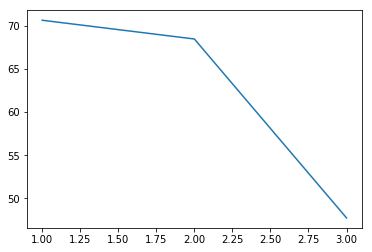

In [95]:
no_of_gaussians, dimensions, weights, centers = meta('set1')
cov_matrices = covariance_data(no_of_gaussians, 'set1')

errors = list()
for i in xrange(4):
    p = 0
    for j in xrange(10):
        index = None
        val = 10000000000
        for k in xrange(10):
            r = np.linalg.norm(centers[k]-meanlist[i][j])
            if r < val:
                val = r
                index = j
        p += val
    errors.append(p)

plt.plot(range(1,4), errors[1:])
plt.show()